In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Multi-domain meshing from simulated data

This notebook demonstrates an example using [tetgen](https://wias-berlin.de/software/tetgen/) as the tetrahedralizer starting from a data volume.

Tetgen file formats:
http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html#ff_poly

In [2]:
from itertools import islice
from collections import namedtuple
import numpy as np
from nanomesh import Volume

### Generate data volume

The cell below creates a simple data volume with a *pore* through the middle. It consists of two domains, 1 for the *bulk* material, and 0 for the pore.

`n`, `m` tune the shape of the volume and the size/location of the pore.

(48, 120, 72)


<IPython.core.display.Javascript object>


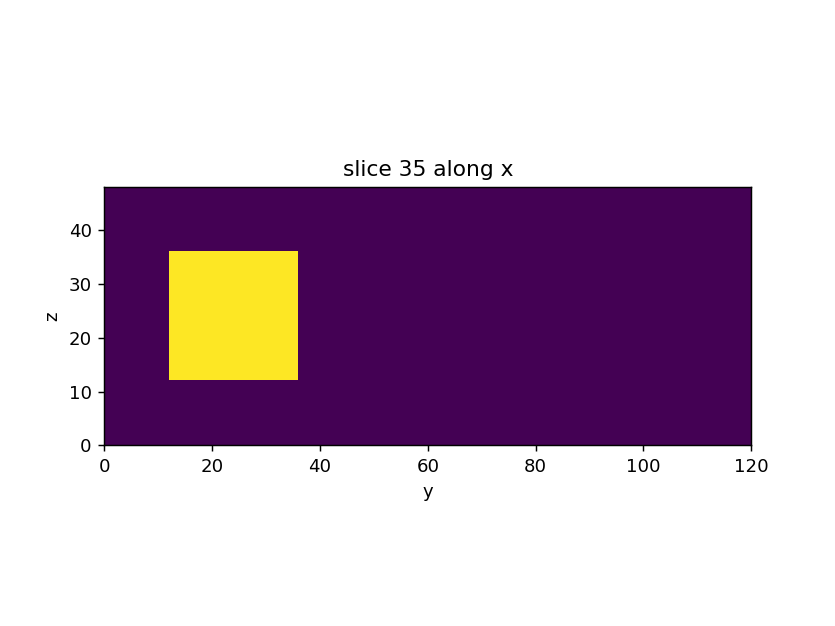

interactive(children=(IntSlider(value=35, description='index', max=71), RadioButtons(description='along', opti…

In [3]:
n = 24
m = 12

data = np.zeros([2*n, 5*n, 3*n], dtype=int)
data[m:3*m, m:3*m, 0:3*n] = 1

print(data.shape)

vol = Volume(data)
vol.show_slice()

### Meshing

Mesh generation consists of two steps.

1. Generate the contour mesh
2. Generate the volume envelope

The contour mesh is the surface separating the domains in the data. In this case, the 1's and 0's, so the contour level does not need to be defined. The surface mesh is completed by wrapping the entire data volume in an envelope. This makes sure that the mesh (including any domain regions) is watertight, which is a requirement for generating a tetrahedral volume mesh.

In [4]:
from nanomesh import Mesher3D

mesher = Mesher3D(vol)
mesher.generate_contour()

Generated contour with 14028 cells


To plot the surface mesh:

(Use `.plot_itk()` for an interactive view)

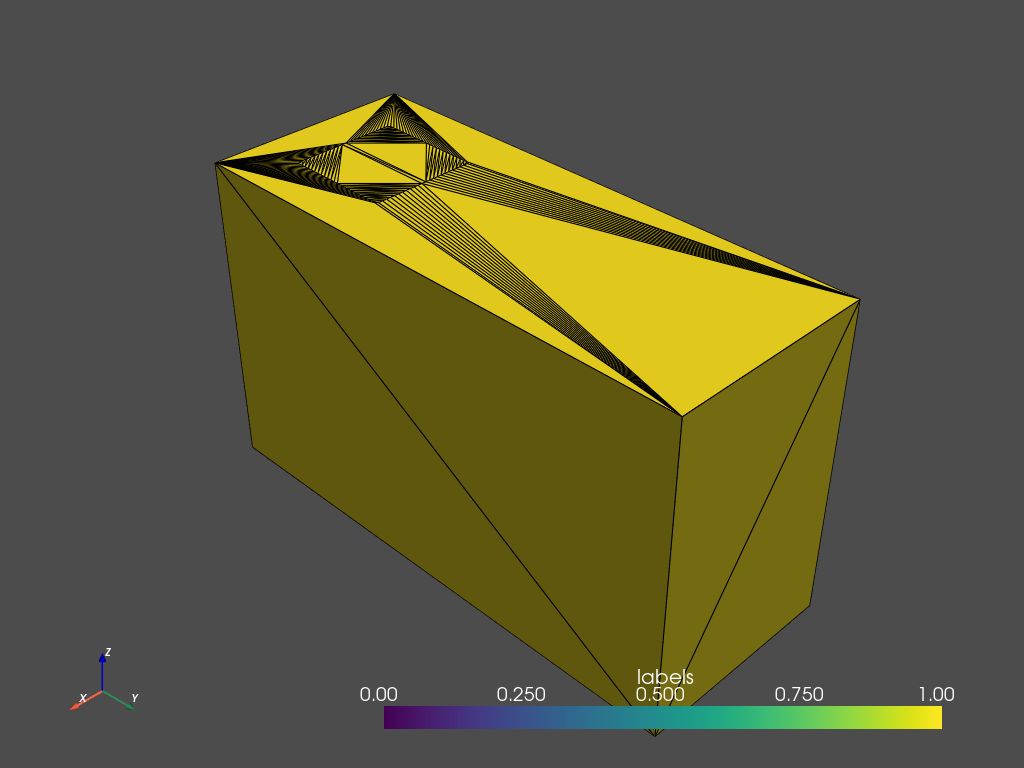

In [5]:
mesher.contour.plot_pyvista(jupyter_backend='static', show_edges=True)

### Generating a tetrahedral volume mesh

The volume mesh is generated using the `.tetrahedralize` method. This returns a tetrahedral mesh. Each domain, separated by the contour mesh defined above, is assigned a value.

The options used below:

- `-A`: Assigns attributes to tetrahedra in different regions.
- `-p`: Tetrahedralizes a piecewise linear complex (PLC).
- `-q`: Refines mesh (to improve mesh quality).
- `-a`: Applies a maximum tetrahedron volume constraint.

Don't make `-a` too small, or the algorithm will take a very long time to complete. If this parameter is left out, the triangles will keep growing without limit.

The region attributes are stored in the `tetgenRef` parameter.

Available options: http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual005.html

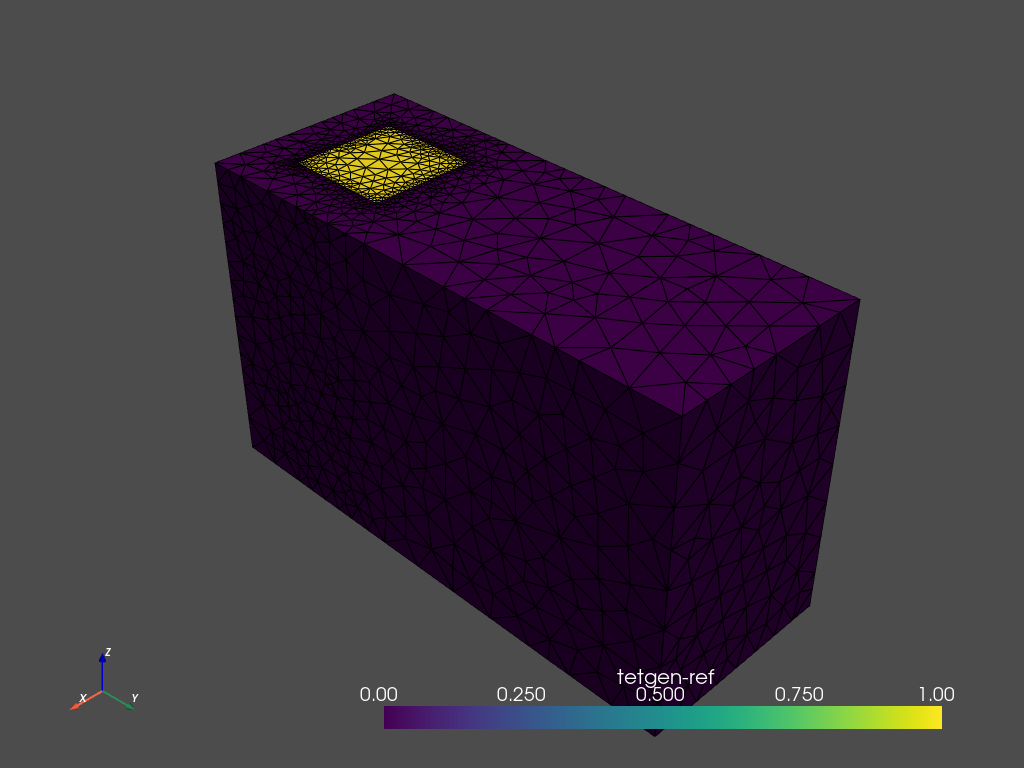

In [6]:
tetras = mesher.tetrahedralize(opts='-pAq -a100')
tetras.plot_pyvista(jupyter_backend='static', show_edges=True)  # Use .plot_itk() for an interactive view

By default, the region attributes are assigned automatically by `tetgen`. Region markers assign attributes to tetrahedra in different regions. After tetrahedralization, the region markers will 'flood' the regions up to the defined boundaries. The elements of the resulting mesh are marked according to the region they belong to (`tetras.cell_data['tetgenRef']`.

It is possible to set your own attributes. The key corresponds to the attribute, and the value must be a point inside the region. The constraint can be used to set the maximum size of the triangles in combination with the `-a` parameter.

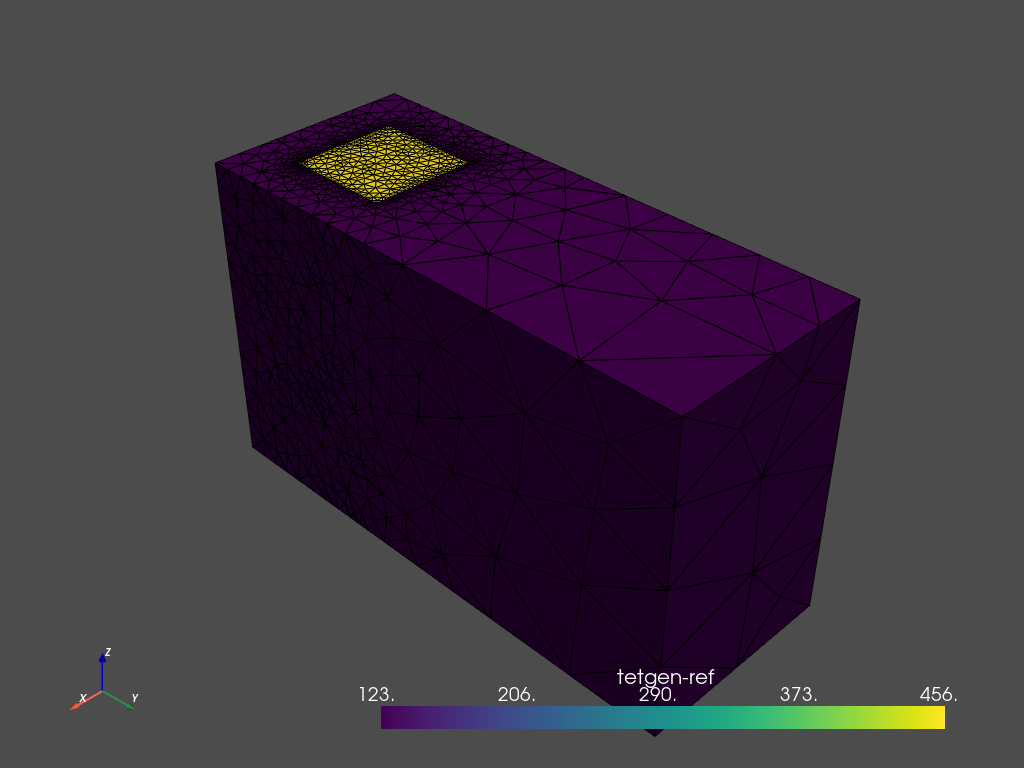

In [7]:
from nanomesh import RegionMarker

region_markers = (
      RegionMarker(123, [0.5, 0.5, 0.5], name='low resolution', constraint=2000),
      RegionMarker(456, [20, 20, 20], name='high resolution', constraint=2),   
)
mesher.set_region_markers(region_markers)

mesh = mesher.tetrahedralize(opts='-pAq -a')

# Use .plot_itk() for an interactive view
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

In [8]:
tetra_mesh = mesh.get('tetra')

for marker in mesher.contour.region_markers:
    num = np.sum(tetra_mesh.cell_data['tetgen-ref'] == marker.label)
    print(f'{num} tetrahedra with attribute `{marker}`')

68401 tetrahedra with attribute `RegionMarker(label=123, point=(0.5, 0.5, 0.5), name='low resolution', constraint=2000)`
67749 tetrahedra with attribute `RegionMarker(label=456, point=(20, 20, 20), name='high resolution', constraint=2)`
